In [114]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, layers
from tensorflow.keras.models import Model

import os
import glob
import tarfile
import random

In [211]:
def plot_loss_curves(history):
    """
    Plots the loss and accuracy curves for the training and validation sets.

    Parameters:
        history (tensorflow.python.keras.callbacks.History): A TensorFlow history object that contains the training and validation metrics.

    Returns:
        None
    """

    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot the accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Hyperparameters

In [115]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
IMG_DIRECTORY = os.path.join("data", "jpg")
BATCH_SIZE = 32
NUM_CLASSES = 102
EPOCHS = 10

In [116]:
# Open the tgz file and extract the data
# with tarfile.open('data/102flowers.tgz', 'r:gz') as tar:
#     tar.extractall()

In [117]:
img_len = len(os.listdir('data/jpg'))
print(f"There are {img_len} images")

There are 8189 images


In [118]:
# Read the labels
mat_data = scipy.io.loadmat('data/imagelabels.mat')
labels = mat_data["labels"]
labels.shape

(1, 8189)

In [119]:
labels = labels.reshape(-1)
labels.shape

(8189,)

In [120]:
labels_df = pd.DataFrame(labels)

In [174]:
image_paths = sorted(os.listdir(IMG_DIRECTORY))
img_df = pd.DataFrame(image_paths)
img_df[0] = img_df[0].apply(lambda x: os.path.join(IMG_DIRECTORY, x))

In [175]:
img_df

,0
0,data/jpg/image_00001.jpg
1,data/jpg/image_00002.jpg
2,data/jpg/image_00003.jpg
3,data/jpg/image_00004.jpg
4,data/jpg/image_00005.jpg
...,...
8184,data/jpg/image_08185.jpg
8185,data/jpg/image_08186.jpg
8186,data/jpg/image_08187.jpg
8187,data/jpg/image_08188.jpg


In [176]:
data_df = pd.concat([img_df, labels_df], axis=1)
data_df.columns = ['filename', 'label']
data_df

,filename,label
0,data/jpg/image_00001.jpg,77
1,data/jpg/image_00002.jpg,77
2,data/jpg/image_00003.jpg,77
3,data/jpg/image_00004.jpg,77
4,data/jpg/image_00005.jpg,77
...,...,...
8184,data/jpg/image_08185.jpg,62
8185,data/jpg/image_08186.jpg,62
8186,data/jpg/image_08187.jpg,62
8187,data/jpg/image_08188.jpg,62


In [177]:
# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data_df['filename'], data_df['label'], test_size=0.15, random_state=42, stratify=data_df['label']
)



# # Split the train data into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.15, random_state=42, stratify=train_labels
)

In [178]:
train_data.shape, train_labels.shape

((5916,), (5916,))

In [179]:
val_data.shape, val_labels.shape, test_data.shape, test_labels.shape

((1044,), (1044,), (1229,), (1229,))

In [180]:
# Ensure that val and test data represent the training data (do they have all classes?)
train_labels_set = set(train_labels) # 102 / 102 classes
val_labels_set = set(val_labels) # 102 / 102 classes
test_labels_set = set(test_labels) # 102 / 102 classes

len(train_labels_set), len(val_labels_set), len(test_labels_set)

(102, 102, 102)

# Visualize some images

In [181]:
img_path = os.path.join("data", "jpg")

In [182]:
def plot_rand_img(path=img_path, labels=labels, figsize=(10, 7)):  
    n_images = len(os.listdir(path))
    rand_idx = random.randint(0, n_images-1)
    image_path = os.listdir(path)[rand_idx]
    label = labels[rand_idx]

    full_image_path = os.path.join(path, image_path)
    plt.figure(figsize=figsize)
    img = plt.imread(full_image_path)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img)
    plt.show();

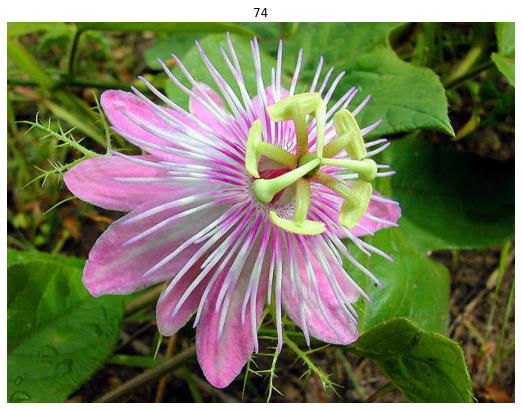

In [183]:
plot_rand_img()

# Create datasets

In [184]:
# Convert series into dataframes
X_train_df = pd.DataFrame(train_data)
y_train_df = pd.DataFrame(train_labels)

X_val_df = pd.DataFrame(val_data)
y_val_df = pd.DataFrame(val_labels)

X_test_df = pd.DataFrame(test_data)
y_test_df = pd.DataFrame(test_labels)

# Combine the Xs and ys into single dataframes
train_data_df = pd.concat([X_train_df, y_train_df], axis=1)
val_data_df = pd.concat([X_val_df, y_val_df], axis=1)
test_data_df = pd.concat([X_test_df, y_test_df], axis=1)

In [185]:
# Create a train generator (with augmentation) and a test generator (no augmentation, used for val data as well)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True 
)


test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [192]:
# Create train, val and test datasets
train_data = train_datagen.flow_from_dataframe(
    dataframe=train_data_df,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=True
)

val_data = test_datagen.flow_from_dataframe(
    dataframe=val_data_df,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_data_df,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
)

Found 5916 validated image filenames.
Found 1044 validated image filenames.
Found 1229 validated image filenames.


# Using a pretrained ResNet

In [200]:
base_model = tf.keras.applications.ResNet50(include_top = False, input_shape=IMG_SHAPE)
x = base_model.output

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)
# Compile the model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)


In [201]:
# Fit the model
hist = model.fit(
    train_data, 
    epochs=20,
    validation_data=val_data,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("best_model", monitor="val_loss", save_best_only=True)]
)

Epoch 1/20


2023-05-11 16:23:03.847960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


185/185 [==============================] - ETA: 0s - loss: 1.8063 - accuracy: 0.6138

2023-05-11 16:27:02.361851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-11 16:27:27.141235: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: best_model/assets
185/185 [==============================] - 280s 1s/step - loss: 1.8063 - accuracy: 0.6138 - val_loss: 5.2890 - val_accuracy: 0.0067
Epoch 2/20
185/185 [==============================] - 252s 1s/step - loss: 0.3137 - accuracy: 0.9136 - val_loss: 5.0274 - val_accuracy: 0.0096
Epoch 3/20
185/185 [==============================] - 1980s 11s/step - loss: 0.1581 - accuracy: 0.9506 - val_loss: 4.3866 - val_accuracy: 0.0757
Epoch 4/20
185/185 [==============================] - 2005s 11s/step - loss: 0.1044 - accuracy: 0.9677 - val_loss: 1.7859 - val_accuracy: 0.5805
Epoch 5/20
185/185 [==============================] - 1009s 5s/step - loss: 0.1071 - accuracy: 0.9653 - val_loss: 3.4812 - val_accuracy: 0.6063
Epoch 6/20
185/185 [==============================] - 613s 3s/step - loss: 0.1744 - accuracy: 0.9572 - val_loss: 0.4849 - val_accuracy: 0.8918
Epoch 7/20
185/185 [==============================] - 469s 3s/step - loss: 0.2528 - accuracy: 0

In [202]:
model.evaluate(val_data)

33/33 [==============================] - 11s 318ms/step - loss: 4.5589 - accuracy: 0.0307


[4.558894157409668, 0.030651340261101723]

In [203]:
model.save("model1.h5")

In [208]:
best_model = tf.keras.models.load_model("best_model")

In [209]:
# Evaluate on the val data
best_model.evaluate(val_data)

2023-05-11 19:06:19.369457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 16s 396ms/step - loss: 0.4849 - accuracy: 0.8918


[0.4849279224872589, 0.8917624354362488]

In [210]:
# Evaluate on the test_data
best_model.evaluate(test_data)

39/39 [==============================] - 15s 372ms/step - loss: 0.6144 - accuracy: 0.8812


[0.6143527030944824, 0.8812042474746704]

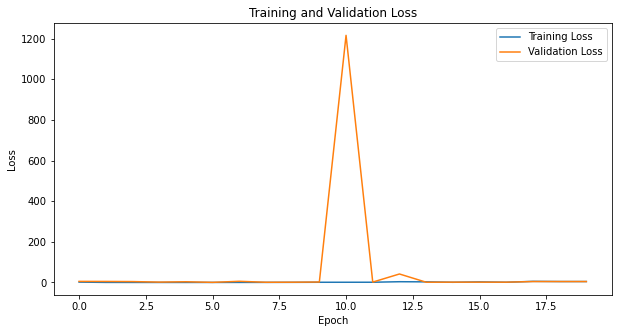

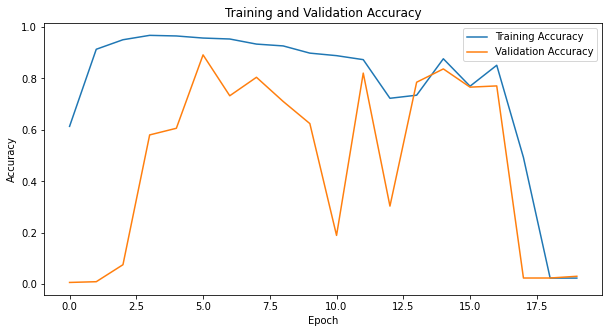

In [212]:
plot_loss_curves(hist)